# Exercise 5

## 1 Constructing the matrix X 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse

In [148]:
def construct_X(M, alphas, Np = None):
    if Np is None:
        Np = np.ceil(np.sqrt(2) * M)
        if Np % 2 == 0: Np += 1 # make Np odd
    s0 = (Np - 1) / 2 #center sensor array
    
    #convert to radians
    alphas = np.array(alphas, dtype=np.float32) / 180 * np.pi 
    
    # some dimensions 
    Na = len(alphas)
    N = Np * Na
    D = M * M
    
    # array holding coordinates of the tomograms pixels
    x, y = np.flip((np.mgrid[0:M, 0:M] - M/2 + .5).reshape(2, -1), axis=0) 
    C = np.array([x, np.flip(y, 0)]) # 2 x D
    
    # normals to the sensor array at different orientations
    n = np.array([np.cos(alphas), np.sin(alphas)], dtype = np.float32) # 2 x Na
    
    # doing the projections
    p = (np.dot(n.transpose(), C) + s0) # Na x D, in range(Np)
    
    # constructing weight and index arrays for X
    lower_bins = np.floor(p)
    lower_bin_weights = 1 - (p - lower_bins)
    upper_bins = lower_bins + 1
    upper_bin_weights = 1 - lower_bin_weights
    
    weights = np.concatenate((lower_bin_weights.reshape(-1), 
                              upper_bin_weights.reshape(-1))) # length: 2 * Na * D
    
    i_indices = np.concatenate((lower_bins.reshape(-1) + Np * np.repeat(np.arange(Na), D), 
                                upper_bins.reshape(-1) + Np * np.repeat(np.arange(Na), D))) # in range(Na*Np)
    j_indices = np.indices(p.shape)[1].flatten()
    j_indices = np.tile(j_indices, 2) # duplicate for upper/lower bins
    
    # construct X matrix
    X = sparse.coo_matrix((weights, (i_indices, j_indices)), shape=(N, D), dtype = np.float32)
    
    return X

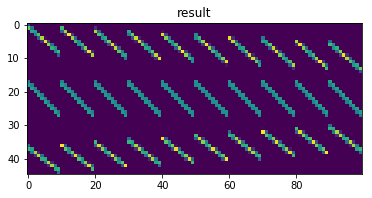

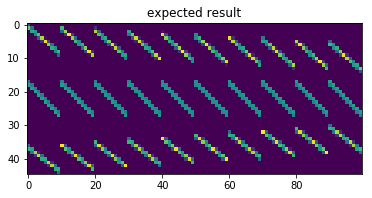

maximum deviation from expected result: 1.341104507446289e-07


In [152]:
M = 10
Np = 15
alphas = [-33, 1, 42]

X_test = construct_X(M, alphas)

plt.imshow(X_test.toarray())
plt.title('result')
plt.show()

X_example = np.load('hs_tomography/X_example.npy')
plt.imshow(X_example)
plt.title('expected result')
plt.show()

print('maximum deviation from expected result: {}'.format(np.max(X_test - X_example)))

## 2 Recovering the image

importing the data

In [6]:
def describe(name, a):
    print('{}: shape: {}, dtype: {}'.format(name, a.shape, a.dtype))

In [34]:
alphas = np.load('hs_tomography/alphas_77.npy')
X_expected = np.load('hs_tomography/X_77.npy').reshape(-1)[0]
X_expected_dense = X_expected.toarray()
y = np.load('hs_tomography/y_77.npy')

describe('alphas', alphas)
describe('y', y)
describe('X_expected_dense', X_expected_dense)
describe('X_example', X_example)

alphas: shape: (90,), dtype: int64
y: shape: (9810,), dtype: float32
X_expected_dense: shape: (9810, 5929), dtype: float32
X_example: shape: (45, 100), dtype: float32
